---
title: Logistic Regression
author: Andrew Dean
date: '2025-04-3'
image: "col4.png"
description: "Momentously builds logistic regression."
code-fold: true
bibliography: refs2.bib
execute:
    warning: false
    message: false
---

In [112]:
#| output: false
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
import torch
from matplotlib import pyplot as plt 
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Abstract

In this blog post, I will conduct a series of experiments using the logistic regression source code linked below. First, I'll implement vanilla gradient descent to verify that the code functions correctly and to explore what it means for it to "work." Next, I'll introduce momentum and compare its efficiency to standard gradient descent. Then, I'll demonstrate the risks of overfitting and how it impacts generalization. Finally, I'll apply logistic regression to a real-world dataset, the Early Detection of Diabetes dataset, to demonstrate the practicality of the algorithm.

Logistic Regression Source Code: [logistic.py](https://github.com/andrewdean1/andrewdean1.github.io/blob/main/posts/logistic-regression/logistic.py)

## Experiments

### Experimental Data

Below I generate synthetic binary classification data to prepare everything needed to train and visualize a logistic regression model.

In [93]:
# Make data
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y

X, y = classification_data(noise = 0.5)

w = torch.linspace(-1, 1, X.shape[1])
w_prev = torch.linspace(-1, 1, X.shape[1])


Then, I define a helper function to plot the data and the decision boundary based on the weight vector $w$.

In [94]:
# Make function to plot data and boundary decision based on w
# Note: this only works for dimension = 2
def plot_data_and_boundary(X, y, w, ax=None):
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        
    ax.set_facecolor('white')  
    ax.grid(True, linestyle='--', alpha=0.7, color='#e0e0e0') 
    
    colors = ["#6a51a3", "#43a2ca"]  
    markers = ["o", "x"]
    
    targets = [0, 1]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], 
                  s=30,  
                  c=colors[i], 
                  alpha=0.4,  
                  edgecolors='#d3d3d3',  
                  marker=markers[i],
                  linewidth=0.8)  

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_values = torch.linspace(x_min, x_max, 100)
    y_values = -(w[0]*x_values + w[2])/w[1]
    ax.plot(x_values, y_values, color='#2c3e50', linewidth=1.5, alpha=0.8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#d3d3d3')
    ax.spines['bottom'].set_color('#d3d3d3')
    
    ax.set_xlabel(r"$x_1$", fontsize=12)
    ax.set_ylabel(r"$x_2$", fontsize=12)
    
    plt.tight_layout()
    
    return ax

In [95]:
# Helper to get accuracy of model
def accuracy(y_pred, y_true):
    correct = (y_pred == y_true).sum()
    total = y_true.shape[0]
    print(correct)
    return correct / total

### Experiment 1: Vanilla Gradient Descent

The goal of this first experiment is to implement Vanilla Gradient Descent, essentially just verifying that the `LogisticRegression` and `GradientDescentOptimizer` classes are correctly implemented. The aim is to ensure that the weight vector $w$ appears visually correct and that the loss decreases monotonically.

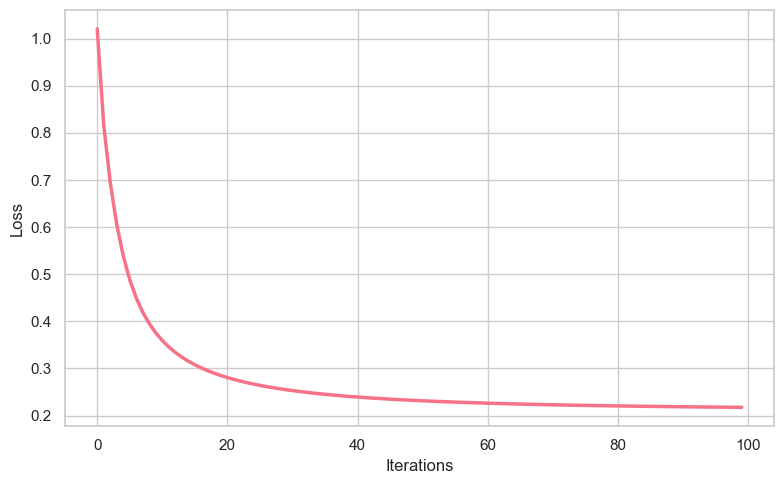

In [96]:
LR_vanilla = LogisticRegression(w)
opt_vanilla = GradientDescentOptimizer(LR_vanilla, w, w_prev)

losses = []

for _ in range(100):
    losses.append(LR_vanilla.loss(X, y))
    opt_vanilla.step(X, y, alpha = 1.5, beta = 0)

sns.set_theme(style="whitegrid")  
colors = sns.color_palette("husl", 1)

plt.figure(figsize=(8, 5))
plt.plot(losses, color=colors[0], linewidth=2.5)
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.tight_layout()

When $p_dim=2$, when $alpha$ is sufficiently small, and $beta = 0$, our loss converges (to weight vector $w$)! It seems to take about 70-80 iterations to converge, correctly decreasing monotonically.

And for our decision boundary:

/var/folders/3c/q12t83w527n5qwlh_p20k_t00000gn/T/ipykernel_13145/530927745.py:17: UserWarning: You passed a edgecolor/edgecolors ('#d3d3d3') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[ix,0], X[ix,1],


<Axes: xlabel='$x_1$', ylabel='$x_2$'>

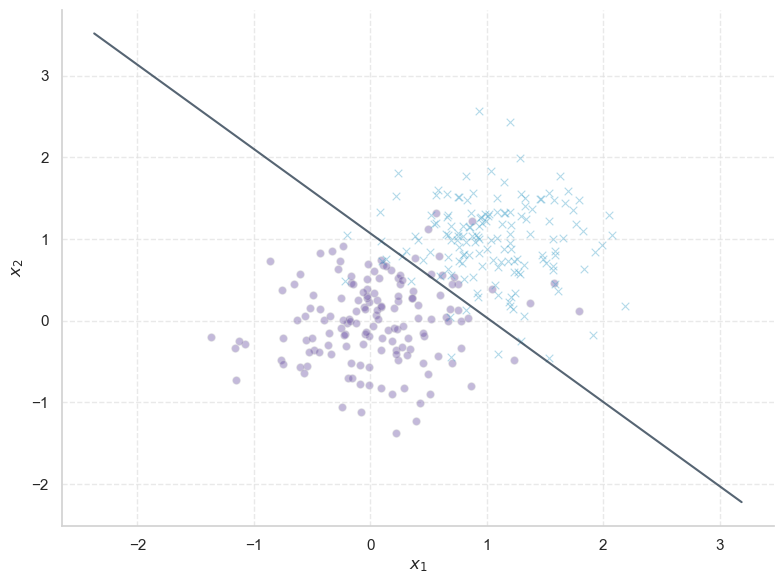

In [97]:
plot_data_and_boundary(X, y, LR_vanilla.w)

That looks great! It correctly and clearly separates the two classes.

### Experiment 2: Gradient Descent with Momentum

The second experiment explores the impact of momentum on logistic regression. With $beta = 0.9$ and an appropriate choice of $alpha$, it should converge more quickly than vanilla gradient descent.

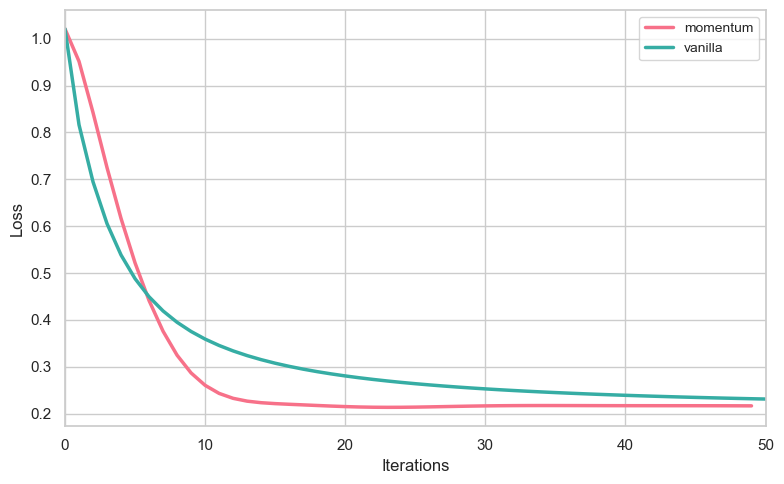

In [98]:
w2 = torch.linspace(-1, 1, X.shape[1])
w_prev2 = torch.linspace(-1, 1, X.shape[1])

LR_momentum = LogisticRegression(w)
opt_momentum = GradientDescentOptimizer(LR_momentum, w2, w_prev2)

losses_mom = []

for _ in range(50):
    losses_mom.append(LR_momentum.loss(X, y))
    opt_momentum.step(X, y, alpha = 0.45, beta = 0.9)


colors = sns.color_palette("husl", 2)

plt.figure(figsize=(8, 5))
plt.plot(losses_mom, label="momentum", color=colors[0], linewidth=2.5)
plt.plot(losses, label="vanilla", color=colors[1], linewidth=2.5)
plt.xlim(0, 50)

plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()

The benefits of momentum are huge! It converges way sooner, in about 14 iterations. 

### Experiment 3: Overfitting

The third experiment examines the effects of overfitting. Logistic regressions do tend to overfit, so let's explore it. First, we'll generate train and test data where p_dim > n_points:

In [99]:
X_train, y_train = classification_data(n_points = 50, noise = 0.5, p_dims = 100)
X_test, y_test = classification_data(n_points = 50, noise = 0.5, p_dims = 100)

Now, I'll fit the model on the training data:

In [100]:
w3 = torch.linspace(-1, 1, X_train.shape[1])
w_prev3 = torch.linspace(-1, 1, X_train.shape[1])

LR3 = LogisticRegression(w3)
opt = GradientDescentOptimizer(LR3, w3, w_prev3)

loss_vec = []

# Training loop
for index in range(100):
    opt.step(X_train, y_train, alpha = 0.3, beta = 0)

final_weights = LR3.w
y_pred_train = LR3.predict(X_train)

acc = accuracy(y_pred_train, y_train)
print(f'Accuracy: {acc}')

tensor(50)
Accuracy: 1.0


There we go, an accuracy of 100% on the training data. Nice. This should definitely be a red flag pointing to overfitting. Let's check the test accuracy:

In [101]:
y_pred_test = LR3.predict(X_test)
acc = accuracy(y_pred_test, y_test)
print(f'Accuracy: {acc}')

tensor(41)
Accuracy: 0.8199999928474426


The test accuracy is notably lower on the testing data, which is what we expect from overfitting.

### Experiment 4: Performance ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍empirical ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data

Let's find a real world data set that we can do binary classification on.

A great dataset that I found is the Early Detection of Diabetes dataset, available on the UCI Machine Learning Repository (@uciDiabetesDataset). This dataset contains medical diagnostic measurements that can help predict whether a patient has diabetes (Yes/No). Some features include:

- Age	
- Gender	
- Polyuria	
- Polydipsia	
- sudden weight loss
- weakness

The target variable is Diabetes outcome (1 = Diabetic, 0 = Non-diabetic). The dataset was originally sourced from the National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK) (@niddkRepository).

Let's take a look at the data:

In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df = pd.read_csv("diabetes_data_upload.csv")
df

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [103]:
# Features
X = df.drop(columns=["class"])

# Outcome
y = df["class"]

# Split into 60% training and 40% temp 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Split temp into 50% validation and 50% test (each 20% of original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Make sure the splits are correct
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")



Training set: (312, 16), Validation set: (104, 16), Test set: (104, 16)


First, we have to do some data preprocessing before we can jump into predictions. The preprocessing below converts categorical features (like "Yes/No" and "Male/Female") into numeric format using one-hot encoding, then transforms them into PyTorch tensors suitable for the logistic regression model. A bias term (column of ones) is added to each feature matrix to account for the intercept in the model.

In [ ]:
# Data preprocessing
# First, let's check data types
print("Data types before conversion:")
print(X.dtypes)

# We need to convert all categorical columns to numeric using one-hot encoding
X_encoded = pd.get_dummies(X)

# Convert boolean columns to integers (0 and 1)
for col in X_encoded.columns:
    if X_encoded[col].dtype == bool:
        X_encoded[col] = X_encoded[col].astype(int)
    elif X_encoded[col].dtype == object:
        X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce')

# Verify all columns are now numeric
print("\nData types after conversion:")
print(X_encoded.dtypes)

# Check for any remaining non-numeric columns
non_numeric = [col for col in X_encoded.columns if not np.issubdtype(X_encoded[col].dtype, np.number)]
if non_numeric:
    print(f"Warning: These columns are still non-numeric: {non_numeric}")
    # Drop any remaining problematic columns
    X_encoded = X_encoded.drop(columns=non_numeric)
    print(f"Dropped problematic columns. Remaining columns: {len(X_encoded.columns)}")

# Convert target variable to numeric (1 for Positive, 0 for Negative)
y_numeric = (y == "Positive").astype(float)

# Split the encoded data
X_train_encoded = X_encoded.loc[X_train.index]
X_val_encoded = X_encoded.loc[X_val.index]
X_test_encoded = X_encoded.loc[X_test.index]

y_train_tensor = torch.tensor(y_numeric.loc[y_train.index].values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_numeric.loc[y_val.index].values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_numeric.loc[y_test.index].values, dtype=torch.float32)

# Convert to PyTorch tensors :)
X_train_tensor = torch.tensor(X_train_encoded.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_encoded.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_encoded.values, dtype=torch.float32)

# Add padding
X_train_tensor = torch.cat((X_train_tensor, torch.ones((X_train_tensor.shape[0], 1))), 1)
X_val_tensor = torch.cat((X_val_tensor, torch.ones((X_val_tensor.shape[0], 1))), 1)
X_test_tensor = torch.cat((X_test_tensor, torch.ones((X_test_tensor.shape[0], 1))), 1)

print(f"\nFeature dimensions after preprocessing: {X_train_tensor.shape[1]}")
print(f"Number of training examples: {X_train_tensor.shape[0]}")

Data types before conversion:
Age                    int64
Gender                object
Polyuria              object
Polydipsia            object
sudden weight loss    object
weakness              object
Polyphagia            object
Genital thrush        object
visual blurring       object
Itching               object
Irritability          object
delayed healing       object
partial paresis       object
muscle stiffness      object
Alopecia              object
Obesity               object
dtype: object

Data types after conversion:
Age                       int64
Gender_Female             int64
Gender_Male               int64
Polyuria_No               int64
Polyuria_Yes              int64
Polydipsia_No             int64
Polydipsia_Yes            int64
sudden weight loss_No     int64
sudden weight loss_Yes    int64
weakness_No               int64
weakness_Yes              int64
Polyphagia_No             int64
Polyphagia_Yes            int64
Genital thrush_No         int64
Genital thrush

Now that we're done manipulating the data, we can finally fit the models. Below, I train two logistic regression models on the diabetes prediction data: one with vanilla gradient descent and one with momentum. I track training and validation losses over 150 epochs, and compare the models' performance through loss curves and accuracy metrics, demonstrating momentum's superior convergence speed and effectiveness.

Epoch 0: Vanilla Loss = 0.6931, Momentum Loss = 0.6931
Epoch 10: Vanilla Loss = 0.6847, Momentum Loss = 0.5519
Epoch 20: Vanilla Loss = 0.6765, Momentum Loss = 0.4205
Epoch 30: Vanilla Loss = 0.6685, Momentum Loss = 0.3607
Epoch 40: Vanilla Loss = 0.6608, Momentum Loss = 0.3294
Epoch 50: Vanilla Loss = 0.6533, Momentum Loss = 0.3088
Epoch 60: Vanilla Loss = 0.6461, Momentum Loss = 0.2937
Epoch 70: Vanilla Loss = 0.6391, Momentum Loss = 0.2818
Epoch 80: Vanilla Loss = 0.6323, Momentum Loss = 0.2722
Epoch 90: Vanilla Loss = 0.6257, Momentum Loss = 0.2640
Epoch 100: Vanilla Loss = 0.6193, Momentum Loss = 0.2571
Epoch 110: Vanilla Loss = 0.6131, Momentum Loss = 0.2509
Epoch 120: Vanilla Loss = 0.6070, Momentum Loss = 0.2455
Epoch 130: Vanilla Loss = 0.6012, Momentum Loss = 0.2407
Epoch 140: Vanilla Loss = 0.5955, Momentum Loss = 0.2363


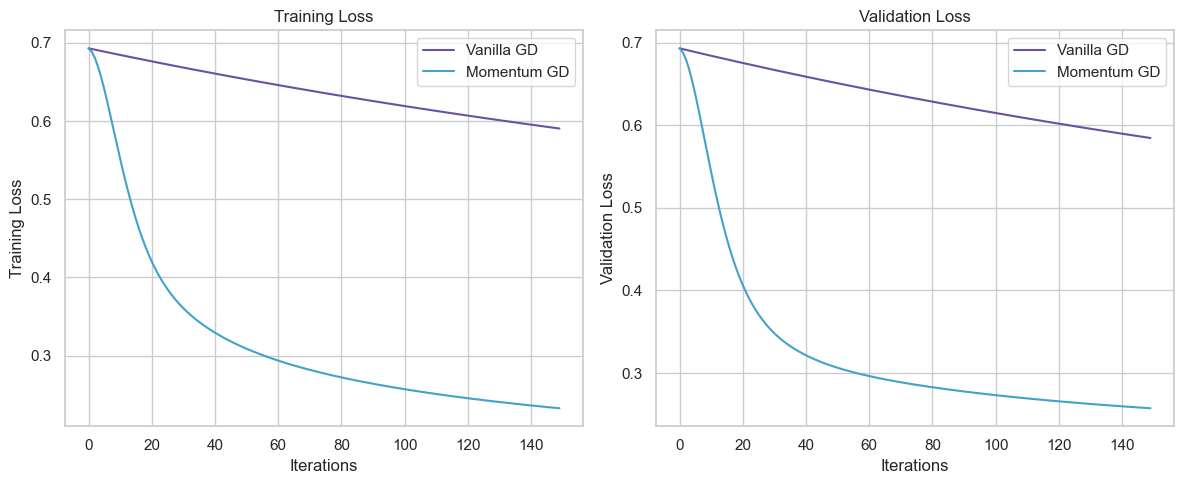

Vanilla GD - Train Acc: 0.4423, Val Acc: 0.4519
Momentum GD - Train Acc: 0.8654, Val Acc: 0.8558


In [107]:
# Normalize features
X_mean = X_train_tensor[:, :-1].mean(0)
X_std = X_train_tensor[:, :-1].std(0) + 1e-8  # to avoid division by zero
X_train_tensor[:, :-1] = (X_train_tensor[:, :-1] - X_mean) / X_std
X_val_tensor[:, :-1] = (X_val_tensor[:, :-1] - X_mean) / X_std
X_test_tensor[:, :-1] = (X_test_tensor[:, :-1] - X_mean) / X_std

# The models!
w_vanilla = torch.zeros(X_train_tensor.shape[1])
w_prev_vanilla = torch.zeros(X_train_tensor.shape[1])
w_momentum = torch.zeros(X_train_tensor.shape[1])
w_prev_momentum = torch.zeros(X_train_tensor.shape[1])

# Create models
LR_vanilla = LogisticRegression(w_vanilla)
opt_vanilla = GradientDescentOptimizer(LR_vanilla, w_vanilla, w_prev_vanilla)
LR_momentum = LogisticRegression(w_momentum)
opt_momentum = GradientDescentOptimizer(LR_momentum, w_momentum, w_prev_momentum)

# Training parameters to make graph show convergence
#(this took a while to get right)
num_epochs = 150
alpha_vanilla = 0.001
alpha_momentum = 0.005
beta_momentum = 0.9

# Initialize tracking for loss
vanilla_train_losses = []
vanilla_val_losses = []
momentum_train_losses = []
momentum_val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Vanilla GD
    vanilla_train_loss = LR_vanilla.loss(X_train_tensor, y_train_tensor)
    vanilla_val_loss = LR_vanilla.loss(X_val_tensor, y_val_tensor)
    
    if not torch.isnan(vanilla_train_loss):
        vanilla_train_losses.append(vanilla_train_loss.item())
        vanilla_val_losses.append(vanilla_val_loss.item())
        opt_vanilla.step(X_train_tensor, y_train_tensor, alpha=alpha_vanilla, beta=0)
    
    # Momentum GD
    momentum_train_loss = LR_momentum.loss(X_train_tensor, y_train_tensor)
    momentum_val_loss = LR_momentum.loss(X_val_tensor, y_val_tensor)
    
    if not torch.isnan(momentum_train_loss):
        momentum_train_losses.append(momentum_train_loss.item())
        momentum_val_losses.append(momentum_val_loss.item())
        opt_momentum.step(X_train_tensor, y_train_tensor, alpha=alpha_momentum, beta=beta_momentum)
    
    # get progress every 10 iterations to see if we're converging
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Vanilla Loss = {vanilla_train_loss:.4f}, Momentum Loss = {momentum_train_loss:.4f}")

plt.figure(figsize=(12, 5))

# training losses
plt.subplot(1, 2, 1)
plt.plot(vanilla_train_losses, label='Vanilla GD', color='#6a51a3')
plt.plot(momentum_train_losses, label='Momentum GD', color='#43a2ca')
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Training Loss", fontsize=12)
plt.legend()
plt.title('Training Loss')

# validation losses
plt.subplot(1, 2, 2)
plt.plot(vanilla_val_losses, label='Vanilla GD', color='#6a51a3')
plt.plot(momentum_val_losses, label='Momentum GD', color='#43a2ca')
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.legend()
plt.title('Validation Loss')

plt.tight_layout()
plt.show()

# get final training and val accuracies
vanilla_train_acc = (LR_vanilla.predict(X_train_tensor) == y_train_tensor).float().mean()
vanilla_val_acc = (LR_vanilla.predict(X_val_tensor) == y_val_tensor).float().mean()
momentum_train_acc = (LR_momentum.predict(X_train_tensor) == y_train_tensor).float().mean()
momentum_val_acc = (LR_momentum.predict(X_val_tensor) == y_val_tensor).float().mean()

print(f"Vanilla GD - Train Acc: {vanilla_train_acc:.4f}, Val Acc: {vanilla_val_acc:.4f}")
print(f"Momentum GD - Train Acc: {momentum_train_acc:.4f}, Val Acc: {momentum_val_acc:.4f}")

Momentum-based gradient descent converges much faster than vanilla gradient descent! While vanilla GD is still slowly decreasing after 150 epochs, momentum GD reaches a convergence. And, the momentum-based model achieves a significantly lower loss value by the end of training (0.2363 vs 0.5955). 

On the test set:

In [108]:
vanilla_test_acc = (LR_vanilla.predict(X_test_tensor) == y_test_tensor).float().mean()
momentum_test_acc = (LR_momentum.predict(X_test_tensor) == y_test_tensor).float().mean()

vanilla_test_loss = LR_vanilla.loss(X_test_tensor, y_test_tensor)
momentum_test_loss = LR_momentum.loss(X_test_tensor, y_test_tensor)

print(f"Test Loss - Vanilla GD: {vanilla_test_loss:.4f}")
print(f"Test Loss - Momentum GD: {momentum_test_loss:.4f}")
print(f"Test Accuracy - Vanilla GD: {vanilla_test_acc:.4f}")
print(f"Test Accuracy - Momentum GD: {momentum_test_acc:.4f}")

Test Loss - Vanilla GD: 0.5837
Test Loss - Momentum GD: 0.2562
Test Accuracy - Vanilla GD: 0.4615
Test Accuracy - Momentum GD: 0.8654


The momentum-based model also achieves (much) better accuracy on the test set, 87% vs 46%, and a significantly lower loss value, 0.2562 vs 0.5837. Momentum rules.

## Discussion

In this blog post, I conducted a series of experiments using custom-built logistic regression code rather than relying on sklearn's implementation. This hands-on approach provided deeper insights into the mathematical foundations of the algorithm, particularly the gradient and loss calculations. I began with vanilla gradient descent, observing how the loss decreased monotonically and how the decision boundary emerged from the optimized weight vector. Next, I explored momentum-based optimization, setting β=0.9 to leverage its accelerating effects. The results clearly demonstrated momentum's superior convergence properties, achieving lower loss values in fewer iterations. Then, I examined overfitting in logistic regression, highlighting the importance of proper regularization and validation in practical applications. And, finally, I applied logistic regression to a real-world dataset, the Early Detection of Diabetes dataset, to demonstrate the practicality of the algorithm. Again, this real world application further supported the pros of momentum-based optimization and it provided valuable insights on the applicability of logistic regression and its performance (it performed quite well).